## Multilayer Perceptron in Julia 1.0.0

### By Thomas Oswald

#### Data 3419, Spring 2020

Multilayer Perceptron (MLP) is a class of feedforward artificial neural network.  In this notebook, I will demonstrate backpropgation for supervised learning on a training data set and show that data that isnt lineraly separable can still be distinguished from each other.  

The MNIST data set consists of $70000$ images of hand written digits, $60000$ of which are typically used as labeled training examples, where the other $10000$ are used for testing your learning model on. The following picture represent a sample of some of the images.

Install the following packages if you havent already.

* Pkg.add("MLDatasets")
* Pkg.add("MLDatasets")
* Pkg.add("TestImages")
* Pkg.add("ImageMagick")

In [1]:
using Pkg
using Plots
theme(:dark)
using MLDatasets, Images, TestImages

train_x, train_y = MNIST.traindata()
test_x, test_y = MNIST.testdata()

(Normed{UInt8,8}[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Normed{UInt8,8}[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Normed{UInt8,8}[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

...

Normed{UInt8,8}[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Normed{UInt8,8}[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Normed{UInt8,8}[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [7, 2, 1, 0, 4, 1, 4, 9, 5, 9  …  7, 8, 9, 0, 1, 2, 3, 4, 5, 6])

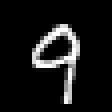

In [2]:
# Number of entries in dataset
num_train = size(train_x)[3]

# View the image
rand_int = rand(1:num_train)
colorview(Gray, train_x[:,:,rand_int]')

In [3]:
# Setup the vectors of data
X_training = []
Y_training = []

# dimensions of a entry
dim = length(train_x[:,:,rand_int])

# 60,000 entries for this MNIST dataset
for i = 1:num_train
    if train_y[i] in [0,1,2,3,4,5,6,7,8,9]
        push!(X_training, reshape(train_x[:,:,i], dim))
        y = zeros(10)
        if train_y[i] == 0                
            y[1] = 1.0
        elseif train_y[i] == 1             
            y[2] = 1.0
        elseif train_y[i] == 2             
            y[3] = 1.0
        elseif train_y[i] == 3            
            y[4] = 1.0
        elseif train_y[i] == 4             
            y[5] = 1.0
        elseif train_y[i] == 5             
            y[6] = 1.0
        elseif train_y[i] == 6            
            y[7] = 1.0
        elseif train_y[i] == 7             
            y[8] = 1.0
        elseif train_y[i] == 8            
            y[9] = 1.0
        else                               
            y[10] = 1.0              
        end
        push!(Y_training,y)
    end
end
    
data_train = [x for x in zip(X_training, Y_training)]

60000-element Array{Tuple{Array{Normed{UInt8,8},1},Array{Float64,1}},1}:
 ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0])
 ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
 ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0])
 ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
 ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0])
 ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0,

In [4]:
# Setup initial weight values and bias values
W2_test = randn(32,784)
W3_test = randn(16,32)
W4_test = randn(10,16)
W5_test = randn(10,10)
W_test = [[0.0], W2_test, W3_test, W4_test, W5_test]

bias_test = [[0.0], randn(32),randn(16),randn(10),randn(10)]

5-element Array{Array{Float64,1},1}:
 [0.0]                                                                                                                                                                                                      
 [-0.315443, -1.88971, -0.742304, 1.12742, 0.604818, -0.795429, -1.596, 0.713184, 0.417807, 1.60711  …  -0.464436, 0.674649, -0.735093, 1.34314, 0.560143, -1.16277, -1.13933, 0.562701, 1.20797, -0.208976]
 [3.14582, 0.624976, -1.04921, 1.90262, 0.079974, 0.257778, 1.33338, 0.0796784, 0.285397, 1.53517, -0.298704, 0.839363, -0.0483696, 0.33869, -1.25246, 0.795263]                                            
 [-0.130552, -0.046462, -1.20329, -0.417056, -0.190467, -0.307903, -0.92665, 0.705676, 0.883336, -0.382935]                                                                                                 
 [-0.418379, -0.214129, -0.184441, -0.0444582, 0.214724, -0.0627494, -1.50999, -0.335364, 0.688643, 0.533458]                                  

## Define Functions

In [5]:
# Sigmoid Function
function σ(v)
    return 1.0/(1.0 + exp(-v))
end

# chain rule on sigmoid
function dσ(v)
    return σ(v)*(1.0 - σ(v))
end

# calculate the pre and post activations for each layer for a given input x
function forward_pass(W,b,x)
    
    z1 = [0.0]
    a1 = x[1]
    
    z2 = W[2]*a1 + b[2]
    a2 = σ.(z2) 
    z3 = W[3]*a2 + b[3]
    a3 = σ.(z3)
    z4 = W[4]*a3 + b[4]
    a4 = σ.(z4)
    z5 = W[5]*a4 + b[5]
    a5 = σ.(z5)
    
    
    return [(z1,a1),(z2,a2),(z3,a3),(z4,a4),(z5,a5)]
end

function output_error(W,b,x)
    activations = forward_pass(W,b,x)
    return (activations[5][2] - x[2]).*dσ.(activations[5][1])
end

function back_prop(W,b,x)
    
    δ5 = output_error(W,b,x)
    activations = forward_pass(W,b,x)
    δ4 = (W[5]'*δ5).*(dσ.(activations[4][1]))
    δ3 = (W[4]'*δ4).*(dσ.(activations[3][1]))
    δ2 = (W[3]'*δ3).*(dσ.(activations[2][1]))
    
    return [[0.0],δ2,δ3,δ4,δ5]
end

back_prop (generic function with 1 method)

### Now we will perform gradient descent

In [6]:
function Stochastic_Gradient_Descent(iterations, num, W_test, bias_test, data, rate)
    for j = 1:iterations
        for i = 1:num
            activations = forward_pass(W_test, bias_test, data[i])
            deltas = back_prop(W_test, bias_test, data[i])
            
             # update Bias # rate = learning rate
            bias_test[5] -= (rate)*deltas[5]
            bias_test[4] -= (rate)*deltas[4]
            bias_test[3] -= (rate)*deltas[3]
            bias_test[2] -= (rate)*deltas[2]
            
            # update Weights
            W_test[5] -= (rate)*deltas[5]*activations[4][2]'
            W_test[4] -= (rate)*deltas[4]*activations[3][2]'
            W_test[3] -= (rate)*deltas[3]*activations[2][2]'
            W_test[2] -= (rate)*deltas[2]*activations[1][2]'
        end
    end
end

Stochastic_Gradient_Descent (generic function with 1 method)

In [7]:
Stochastic_Gradient_Descent(100,num_train, W_test,bias_test, data_train, 0.70)

### Testing on the MNIST training data sets

In [8]:
function Predict(num, data)
    max_weight = findmax(forward_pass(W_test, bias_test, data[num])[5][2]) # find the max weight and the row it is on
    max_data = findmax(data[num][2]) # Find what row the identifier is on.
    
    if max_weight[2] == max_data[2] # check to see if the row with the maximum weight is the same row for the number identifier
        println("Success! The entry ",num,", corresponds with the number ", max_data[2]-1)
    else
        println("Not a match! The entry ",num," does not correspond with the number ", max_data[2]-1)
        println("The maximum weight is ",max_weight[1]," and is on the ",max_weight[2]," row.")
        println("For this number ",max_data[2]-1,", it should be on the ",max_data[2]," row of the last ativation layer.")
        println("This entry is being misclassified as a ",max_weight[2]-1,".")
    end
    println("")
    println("Below is the what the handwritten number.")
    return colorview(Gray, reshape(data[num][1], (28,28))')
end

# to test how accurate gradient descent is with the current iteration setup.
function accuracy_check(num,W_test,bias_test,data)
    count = 0
    for i = 1:num
        if findmax(forward_pass(W_test, bias_test, data[i])[5][2])[2]-1 == findmax(data[i][2])[2]-1
            count += 1
        end
    end
    accuracy = (count/num)*100
    println("With the current iteration setup, we are ",accuracy,"% accurate on the training set weights")
end

accuracy_check (generic function with 1 method)

Success! The entry 30569, corresponds with the number 8

Below is the what the handwritten number.


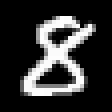

In [9]:
# run several times if you like
rand_int = rand(1:num_train)
Predict(rand_int, data_train)

In [10]:
accuracy_check(num_train,W_test,bias_test, data_train)

With the current iteration setup, we are 92.14333333333333% accurate on the training set weights


### Now we test this on the MNIST test data sets

In [11]:
X_test = []
Y_test = []

# dimensions of a entry
dim = length(test_x[:,:,1])

# Number of entries in dataset
num_test = size(test_x)[3]

for i = 1:num_test    # 10,000 entries for this MNIST dataset
    if test_y[i] in [0,1,2,3,4,5,6,7,8,9]
        push!(X_test, reshape(test_x[:,:,i], dim))
        y = zeros(10)
        if test_y[i] == 0                
            y[1] = 1.0
        elseif test_y[i] == 1             
            y[2] = 1.0
        elseif test_y[i] == 2             
            y[3] = 1.0
        elseif test_y[i] == 3            
            y[4] = 1.0
        elseif test_y[i] == 4             
            y[5] = 1.0
        elseif test_y[i] == 5             
            y[6] = 1.0
        elseif test_y[i] == 6            
            y[7] = 1.0
        elseif test_y[i] == 7             
            y[8] = 1.0
        elseif test_y[i] == 8            
            y[9] = 1.0
        else                               
            y[10] = 1.0              
        end
        push!(Y_test,y)
    end
end
    
data_test = [x for x in zip(X_test, Y_test)]

10000-element Array{Tuple{Array{Normed{UInt8,8},1},Array{Float64,1}},1}:
 ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0])
 ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
 ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
 ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
 ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0])
 ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0, 0.0,

### Now we will perform gradient descent

In [12]:
Stochastic_Gradient_Descent(100,num_test, W_test,bias_test, data_test, 0.70)

Success! The entry 4726, corresponds with the number 2

Below is the what the handwritten number.


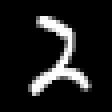

In [34]:
# run several times if you like
rand_int2 = rand(1:num_test)
Predict(rand_int2, data_test)

In [14]:
accuracy_check(num_test,W_test,bias_test,data_test)

With the current iteration setup, we are 93.85% accurate on the training set weights
